In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pprint import pprint as pp
import networkx as nx

In [2]:
!qbraid jobs enable amazon_braket

You have already enabled qBraid Quantum Jobs in the amazon_braket environment.


# Interfacing with Aquila
Import AwsDevice and use it to obtain a handle to the Aquila resource by ARN identifier. Get device properties, such as parameter constraints and the C6 coeffiecient quantifying the Rydberg interaction.

In [3]:
# !qbraid envs activate amazon_braket

In [3]:
from braket.ahs.atom_arrangement import AtomArrangement
import numpy as np
from quera_ahs_utils.plotting import show_register
import matplotlib.pyplot as plt

a = 6.1e-6  # meters


# x = [0, 3, 3, 0, 1, 2, 2, 1,]# 4, 5, 5, 4, 6, 9, 9, 6, 7, 8, 8, 7, 10, 11, 11, 10, 12, 15, 15, 12, 13, 14, 14, 13, 16, 17, 17, 16]
# y = [0, 0, 3, 3, 1, 1, 2, 2,]# 2, 2 , 1, 1, 0, 0, 3, 3, 1, 1, 2, 2, 2, 2, 1, 1, 0, 0, 3, 3, 1, 1, 2, 2, 2, 2, 1, 1]

# x = [a*val for val in x]
# y = [a*val for val in y]

points = [(-0.04100006,-1.4860001),
(-1.011,-1.4760001),
(-0.021000061,-2.426),
(-0.021000061,-0.50600004),
(0.93899995,-1.416),
(0.008999939,0.47399995),
(0.02899994,1.464),
(-0.95100003,1.5239999),
(0.05899994,2.394),
(1.009,1.454),
]

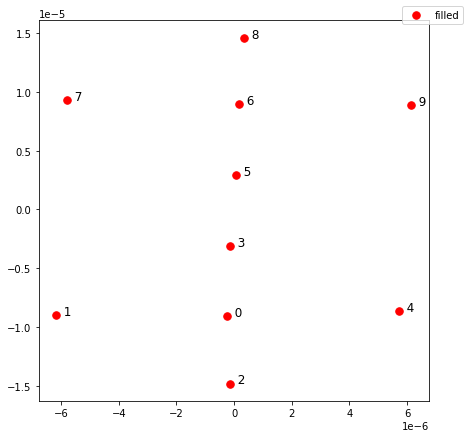

In [4]:
register = AtomArrangement()
# for i in range(len(x)):
#     register.add([x[i], y[i]])
for x,y in points:
    register.add([a*x,a*y])

fig = show_register(register)
plt.show()

In [5]:
from braket.ahs.hamiltonian import Hamiltonian

H = Hamiltonian()

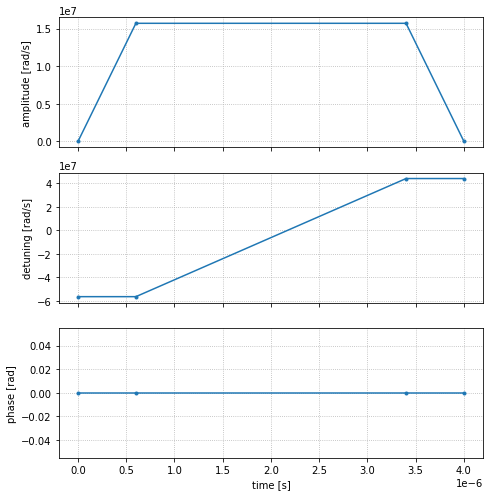

<Figure size 432x288 with 0 Axes>

In [16]:
from quera_ahs_utils.plotting import show_global_drive 
from quera_ahs_utils.drive import get_drive

omega_min = 0       
omega_max = 2.5e6 * 2 * np.pi
detuning_min = -9e6 * 2 * np.pi
detuning_max = 7e6 * 2 * np.pi

time_max = 4e-6
time_ramp = 0.15*time_max

time_points = [0, time_ramp, time_max - time_ramp, time_max]
omega_values = [omega_min, omega_max, omega_max, omega_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]

drive = get_drive(time_points, omega_values, detuning_values, phase_values)
H += drive

show_global_drive(drive)
plt.savefig("default_drive.png")
plt.show()

In [7]:
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=H
)

In [8]:
from braket.devices import LocalSimulator

classical_device = LocalSimulator("braket_ahs")

nshots = 10
task = classical_device.run(ahs_program, shots=nshots)

# The result can be downloaded directly into an object in the python session:
result = task.result()

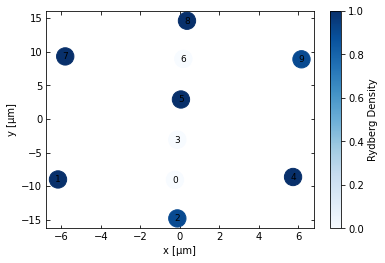

In [13]:
from quera_ahs_utils.analysis import get_avg_density
from quera_ahs_utils.plotting import plot_avg_density

n_rydberg = get_avg_density(result)
fig,ax = plot_avg_density(n_rydberg, register,cmap=plt.cm.Blues)
plt.savefig("two_four_petal_default_drive.png")
plt.show()

In [10]:
def points_to_unit_graph(scale=1, atom_list=[]):
    edge_dict = {}
    for i in range(len(atom_list)):
        for j in range(len(atom_list)):
            if(j == i):
                continue
            if np.sqrt((atom_list[i][0]-atom_list[j][0])**2 + (atom_list[i][1]-atom_list[j][1])**2) <= scale:
                if(i in edge_dict):
                    edge_dict[i].append(j)
                else:
                    edge_dict[i] = [j]
    print(edge_dict)
    return nx.from_dict_of_lists(edge_dict)
def scale_units(atom_pos, scale=4.0*1e-6):
    out = []
    for a in atom_pos:
        out.append(a[0] * scale, a[1] * scale)

In [11]:
# atoms, graph = generate_unit_disk(atoms_l, atoms_w)
print(points)
atom_pos = [(0,0),(0,1),(0,-1),(1,0), (-1,0)]
atoms = AtomArrangement()
for atom in points:
    atoms.add(atom)
graph = points_to_unit_graph(scale=1, atom_list=points)

[(-0.04100006, -1.4860001), (-1.011, -1.4760001), (-0.021000061, -2.426), (-0.021000061, -0.50600004), (0.93899995, -1.416), (0.008999939, 0.47399995), (0.02899994, 1.464), (-0.95100003, 1.5239999), (0.05899994, 2.394), (1.009, 1.454)]
{0: [1, 2, 3, 4], 1: [0], 2: [0], 3: [0, 5], 4: [0], 5: [3, 6], 6: [5, 7, 8, 9], 7: [6], 8: [6], 9: [6]}


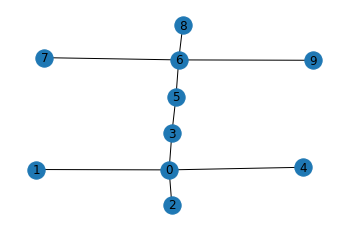

In [15]:
fig, ax = plt.subplots()
pos = {ii: points[ii] for ii in graph.nodes()}
nx.draw(graph, pos=pos, ax=ax, with_labels=True)
plt.savefig("con_two_four_petal.png")
plt.show()

In [16]:
from braket.aws import AwsDevice

qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

# Capabilities, constraints and performance metrics are stored as 'paradigm' attribute of AwsDevice.
capabilities = qpu.properties.paradigm
pp(capabilities.dict())

# get C6 coefficient in rad m^6/sec Pull from capabilities attribute
C6 = float(capabilities.rydberg.dict()['c6Coefficient'])

{'braketSchemaHeader': {'name': 'braket.device_schema.quera.quera_ahs_paradigm_properties',
                        'version': '1'},
 'lattice': {'area': {'height': Decimal('0.000076'),
                      'width': Decimal('0.000075')},
             'geometry': {'numberSitesMax': 256,
                          'positionResolution': Decimal('1E-7'),
                          'spacingRadialMin': Decimal('0.000004'),
                          'spacingVerticalMin': Decimal('0.000004')}},
 'performance': {'lattice': {'positionErrorAbs': Decimal('1E-7')},
                 'rydberg': {'rydbergGlobal': {'rabiFrequencyErrorRel': Decimal('0.02')}}},
 'qubitCount': 256,
 'rydberg': {'c6Coefficient': Decimal('5.42E-24'),
             'rydbergGlobal': {'detuningRange': (Decimal('-125000000.0'),
                                                 Decimal('125000000.0')),
                               'detuningResolution': Decimal('0.2'),
                               'detuningSlewRateMax': Decimal(

# Combinatorial optimization of maximum independent set

This notebook will outline how to do some optimization tasks using QuEra's analog Hamiltonian simulator Aquila. It closely follows the recent paper [Quantum optimization of maximum independent set using Rydberg atom arrays. S. Ebadi et. al. 2022](https://www.science.org/doi/10.1126/science.abo6587)

Maximum independent set (MIS) is a prototypical optimization problem on graphs. Given a graph $G=(V,E)$ of vertices $V$ and edges $E$, the challenge is to find the largest set of vertices $I\subseteq V$ such that no two vertices in $I$ share an edge. This task is usually hard for a broad class of graph instances using classical computers, as they have to resort to "educated guess and check" of every solution in a space of solutions that is exponentially large in the number of vertices.

## Encoding MIS with Rydberg atoms

The basic idea of this quantum optimization is to **encode the maximum independent set solution into the ground state of a Hamiltonian**, then use the quantum adiabatic algorithm (QAA) to anneal from some simple-to-prepare initial state to that ground state. The Rydberg Hamiltonian naturally implements the MIS in its ground state using the Rydberg blockade

$$\hat H/\hbar = \frac{1}{2}\sum_i\Omega(t)|g_i\rangle\langle r_i| + \Omega^*(t)|r_i\rangle\langle g_i| \;-\;\sum_i\Delta_i(t)\hat n_i + \sum_{ij} V_{ij}\hat n_i\hat n_j\qquad\text{where}\qquad n=|r_i\rangle\langle r_i|\qquad\text{and}\qquad V_{ij}=\frac{C_6}{|\vec x_i - \vec x_j|^6}$$.

where each atom is set at a position $\vec x_i$. For $\Delta<0$, the ground state prefers to have no atoms in the Rydberg state, while for $\Delta>0$ the ground state prefers to have many atoms in the ground state. The interaction term $V_{ij}$ is an energy penalty if two close by atoms are both in the Rydberg state and forms the basis for the Rydberg Blockade. The **Blockade radius** is the distance at which the single-body detuning term $\Delta$ equals the interaction term $V_{ij}$.

$$V_{ij}=\Delta \quad\Rightarrow\quad R_b = |\vec x_i - \vec x_j| = \bigg(\frac{C_6}{\Delta}\bigg)^{1/6}$$

If two atoms are closer than this radius, they are blockaded and it is energetically favorable to only have one atom in the Rydberg state. If two atoms are further than this radius, they are not blockaded and it is energetically favorable to have both atoms in the Rydberg state.

## Unit disk graphs

Analagously, this blockade can be seen as an independent set condition on a **unit disk graph** (UDG). A UDG is a geometric graph where each vertex $i$ has a position $\vec r_i$, and vertices $i$ and $j$ are connected by an edge if and only if they are closer than the unit disk radius $R_u>|\vec r_i - \vec r_j|$. Let us prepare a small example unit disk graph

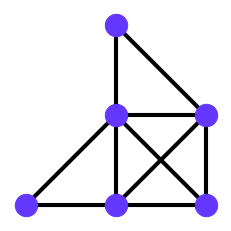

In [4]:
from iquhack_utils import visualize_graph

def kings_graph(numx,numy,filling=0.7,seed=None):
    '''
    Generate a next nearest neighbor graph with a lattice constant 1, with some number of nodes removed
    numx    - number of grid points in the X direction
    numy    - number of grid points in the Y direction
    filling - Fraction of vertices to be kept. Total number of vertices is int(numx*numy*filling)
    
    Returns
    pos     - [N x 2] array of points on a square grid
    graph   - networkx connectivity graph
    '''
    xx,yy = np.meshgrid(range(numx),range(numy))
    num_points = int(numx*numy*filling)
    rand = np.random.default_rng(seed=seed)
    # Generate points
    points = np.array([xx.flatten(),yy.flatten()]).T
    points = points[rand.permutation(numx*numy)[0:num_points],:]
    # Generate a unit disk graph by thresholding distances between points.
    distances = np.sqrt((points[:,0] - points[:,0,None])**2 + (points[:,1] - points[:,1,None])**2)
    graph     = nx.Graph(distances<np.sqrt(2)+1E-10)
    
    graph.remove_edges_from(nx.selfloop_edges(graph))
    return points, graph

# Make a small king's graph
pos,small_G = kings_graph(3,3,0.7,seed = 1)



fig = plt.figure()
ax = plt.subplot(1,1,1)
visualize_graph(ax,small_G,pos)
plt.show()

## Optimal unit disk radius

The MIS on a UDG can then be encoded by setting the blockade radius equal to the unit disk radius $R_b=R_u$ by scaling the position of each vertex in the unit disk graph to a position of an atom in the array $\vec x_i = a* \vec r_i$. The unit disk radius can be chosen from a range of values, as long as it does not change the connectivity of the unit disk graph. In particular, the unit disk radius can be chosen to be between $R_\text{min}<R_b<R_\text{max}$. Here, $R_\text{min}$ is the minimum radius the unit disk can be, or equivalently the largest distance between vertices connected by an edge. $R_\text{max}$ is the maximum radius the unit disk can be, or equivalently the smallest distance between vertices that are not connected by an edge. To maximize the energy difference between blockaded and unblockaded edges, the optimal unit disk radius $R_u = \sqrt{R_\text{min} R_\text{max}}$. For more details, see [this documentation page](https://queracomputing.github.io/Bloqade.jl/dev/tutorials/1.blockade/main/)

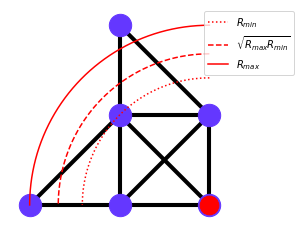

In [5]:
def find_UDG_radius(position, graph):
    '''
    Computes the optimal unit disk radius for a particular set of positions and graph.
    position   - [N x 2] array of points
    graph       - network connectivity graph. This should be a unit disk graph.
    
    returns
    radius      - Optimal unit disk radius of the graph
    rmin        - Minimum distance
    rmax        - Maximum distance
    '''
    
    dists = np.sqrt((position[:,0,None] - position[:,0])**2
               + (position[:,1,None] - position[:,1])**2)
    rmin = 0
    rmax = np.inf
    for i in range(position.shape[0]):
        for j in range(i+1,position.shape[0]):
            if (i,j) in graph.edges:
                if rmin<dists[i,j]:
                    rmin = dists[i,j]
            elif (i,j) not in graph.edges:
                if rmax>dists[i,j]:
                    rmax = dists[i,j]
    
    if rmin>rmax:
        print(rmin,rmax)
        raise BaseException("Graph is not a unit disk graph!")
    
    return np.sqrt(rmin*rmax),rmin,rmax

# Find unit disk radius
unitdisk_radius,min_radius,max_radius = find_UDG_radius(pos,small_G)




# Visualize using networkx
fig = plt.figure()
ax = plt.subplot(1,1,1)
visualize_graph(ax,small_G,pos)


# Draw the minimum and maximum unit disk radius of the graph
x0,y0 = (2,0)
angles = np.linspace(np.pi/2,np.pi,1001)
ax.plot(min_radius*np.cos(angles)+x0,min_radius*np.sin(angles)+y0,
        linestyle=":",color="red",label="$R_{min}$")
ax.plot(unitdisk_radius*np.cos(angles)+x0,unitdisk_radius*np.sin(angles)+y0,
        linestyle="--",color="red",label="$\sqrt{R_{max}R_{min}}$")
ax.plot(max_radius*np.cos(angles)+x0,max_radius*np.sin(angles)+y0,
        linestyle="-",color="red",label="$R_{max}$")

ax.scatter(x0,y0,color="red",zorder=3,marker="o",s=350)
ax.set_xlim((-0.25,3))
plt.legend(loc="upper right",)
plt.show()

## Encoding the graph onto the quantum register

The next step is to take the logical unit disk graph and encode it onto the physical atoms. This is set by the characteristic scale of the final detuning, which we take to be $\Delta = 20\times 10^6$rad/sec. Note that while this scaling is a good first guess, it may not be an optimal value.

Blockade radius of Rydberg system is 8.044e-06m
Unit disk radius of logical graph is 1.682


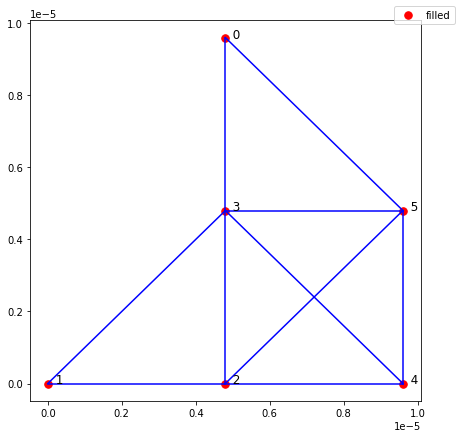

In [6]:
from iquhack_utils import get_blockade_radius,C6
Delta_final = 20e6 # rad/sec

# Find blockade radius
blockade_radius = get_blockade_radius(Delta_final, 0) # no rabi amplitude at the end
print('Blockade radius of Rydberg system is {:0.3e}m'.format(blockade_radius))
print('Unit disk radius of logical graph is {:0.3f}'.format(unitdisk_radius))

# Compute scaling value a, which converts between logical and physical coordinates
a = blockade_radius / unitdisk_radius

# Generate the atom register
from braket.ahs.atom_arrangement import AtomArrangement
small_register = AtomArrangement()
for x in pos:
    small_register.add((a * x).round(7))
    
    
from quera_ahs_utils.plotting import show_register
show_register(small_register,blockade_radius = a*1.5)


## Adiabatic Evolution

One canonical algorithm to prepare the ground state of a Hamiltonian is adiabatic annealing. Here, the system is initialized into an easy-to-prepare ground state of a Hamiltonian. In this case, we choose the initial Hamiltonian with $\Delta<0$, whose ground state corresponds to every atom in the ground state $|g\rangle$. Then, the Hamiltonian is slowly changed ("annealed") from one set of parameters to another. First, the transverse field $\Omega$ is slowly turned on, which lets different states mix. Then, the field $\Delta$ is slowly turned from negative to positive. Finally, the transverse field $\Omega$ is slowly turned off. If this protocol is slow enough, the final state will be the ground state of the Hamiltonian by the **adiabatic theorem**, which states
   >A physical system remains in its *instantaneous* eigenstate if a given perturbation is acting on it slowly enough and if there is a gap between the eigenvalue and the rest of the Hamiltonian's spectrum. (Born & Fock, 1928)
   
Lets define a protocol that does exactly this:

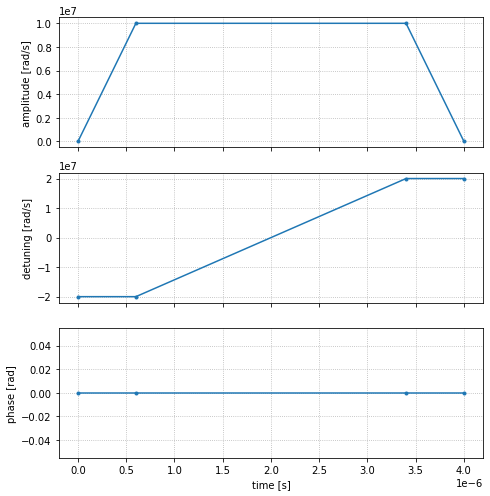

In [7]:
# Define a set of time points
time_points = [0, 0.6e-6, 3.4e-6, 4e-6]

# Define the strength of the transverse field Ω
amplitude_min = 0
amplitude_max = 10e6  # rad / sec

# Define the strength of the detuning Δ
Delta_initial = -20e6     # rad / sec
Delta_final = Delta_final # Defined above

# Define the total drive
from quera_ahs_utils.plotting import show_global_drive
from quera_ahs_utils.drive import get_drive 

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]  # piecewise linear
detuning_values = [Delta_initial, Delta_initial, Delta_final, Delta_final]  # piecewise linear
phase_values = [0, 0, 0, 0]  # piecewise constant


# Define the drive
drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
show_global_drive(drive);

### Packaging the AHS program
Finally, we construct our AHS program from the atomic registers, and the Hamiltonian defined above.

In [8]:
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
small_ahs_program = AnalogHamiltonianSimulation(
    register=small_register, 
    hamiltonian=drive
)

### Simulating with the local emulator

The program can be run one of two ways. For small systems, it may be run on a classical simulator, locally.

In [9]:
from braket.devices import LocalSimulator
device = LocalSimulator("braket_ahs")
small_ahs_run = device.run(small_ahs_program, shots=1000)


def save_result_json(json_file,result):
    '''
    Helper function to save results locally
    '''
    result_dict = {"measurements":[]}
    for measurement in result.measurements:
        shot_result = {
            "pre_sequence":[int(qubit) for qubit in measurement.pre_sequence],
            "post_sequence":[int(qubit) for qubit in measurement.post_sequence]
                      } 
        result_dict["measurements"].append(shot_result)
        
    with open(json_file,"w") as io:
        json.dump(result_dict,io,indent=2)
        
def open_json(json_file):
    '''
    Helper function to load and open json data
    '''
    with open(json_file,"r") as io:
        return json.load(io) 

    
# Results are loaded and saved to file
result  = small_ahs_run.result()
save_result_json("small_kings_graph_mis.json",result)


Lets see how some of these results look on the logical graph...

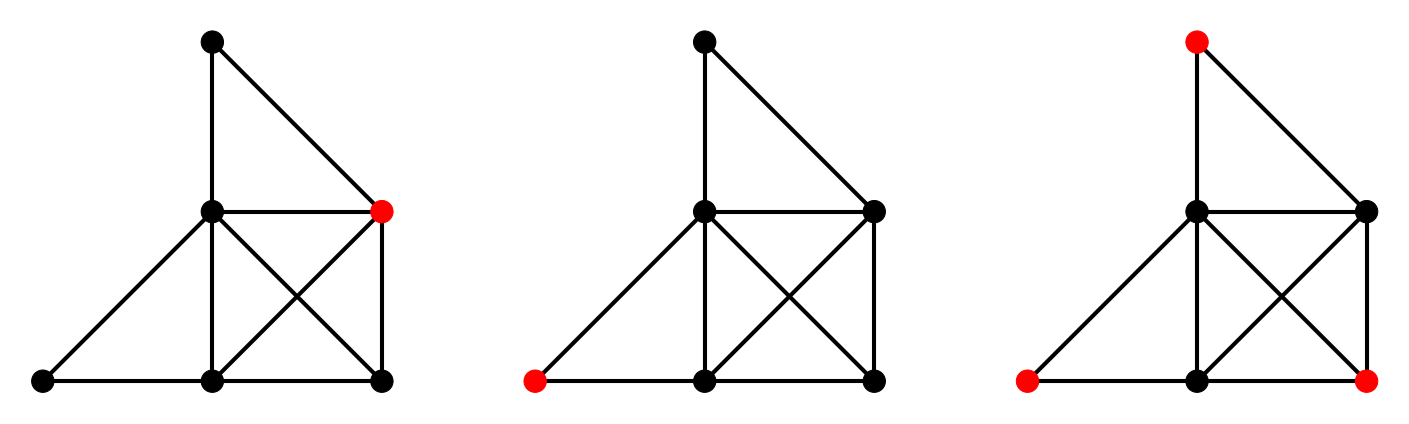

In [10]:
result_json = open_json("small_kings_graph_mis.json")
nmeas = len(result_json["measurements"])    
seqs = [result_json["measurements"][i]["post_sequence"] for i in [0,1,nmeas-1]]

fig = plt.figure(figsize=(25,15))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    
    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[seqs[i][j]] for j in range(len(seqs[i]))]
    visualize_graph(ax,small_G,pos,node_colors = seqs_color)
    
plt.show()

### Minimal post-processing

Let us do some minimal post-processing on these results. While the independent set constraint is a hard logical constraint, it is a soft constraint in the Rydberg blockade. Sometimes each bit string may spurriously violate the independent set constraint. The simplest way to fix this is to post-process the state by randomly removing adjacent vertices.

In [11]:
def postprocess_MIS(G,results):
    '''
    Removes vertices that violate the independent set condition
    G - networkx graph
    results - an AWS AnalogHamiltonianSimulationQuantumTaskResult
    
    returns
    data_out - a list of bitstrings which are valid independent sets of G
    '''
    data_out = []
    for measurement in results["measurements"]: # For each measurement...
        pre_sequence = np.array(measurement["pre_sequence"])
        post_sequence = np.array(measurement["post_sequence"])
        if np.any(pre_sequence==0): continue # skip anyshots with defects
            
        bitstring = post_sequence
        inds = np.nonzero(bitstring==0)[0]    # Find indices of IS vertices
        subgraph = nx.subgraph(G,inds)        # Generate a subgraph from those vertices. If the bitstring is an independent set, this subgraph has no edges.
        inds2 = nx.maximal_independent_set(subgraph,seed=0) # Find the mIS of this subgraph. If there are no edges, it is the original bitstring. Else, it randomly chooses within each graph.
        payload = np.ones(len(bitstring))     # Forge into the correct data structure (a list of 1s and 0s)
        payload[inds2] = 0
        data_out.append(payload)
        
    if len(data_out) == 0: 
        raise ValueError("no independent sets found! increase number of shots.")
        
    return np.asarray(data_out)

def analysis_MIS(graph,result_json):
    '''
    Helper function to analyze a MIS result and plot data
    '''

    post_bitstrings = np.array([q["post_sequence"] for q in result_json["measurements"]])
    pp_bitstrings = postprocess_MIS(graph, result_json)


    IS_sizes = np.sum(1-pp_bitstrings,axis=1)
    unique_IS_sizes,counts = np.unique(IS_sizes,return_counts=True)


    avg_no_pp = 'Average pre-processed size:  {:0.4f}'.format( (1-post_bitstrings).sum(axis=1).mean() )
    avg_pp = 'Average post-processed IS size: {:0.4f}'.format(IS_sizes.mean())
    print(avg_no_pp)
    print(avg_pp)
    plt.bar(unique_IS_sizes,counts/counts.sum())
    plt.xticks(unique_IS_sizes)
    plt.xlabel("IS sizes",fontsize=14)
    plt.ylabel("probability",fontsize=14)
    plt.show()
    
    return IS_sizes,pp_bitstrings
    



Average pre-processed size:  2.9730
Average post-processed IS size: 2.9730


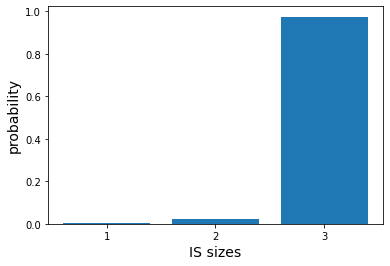

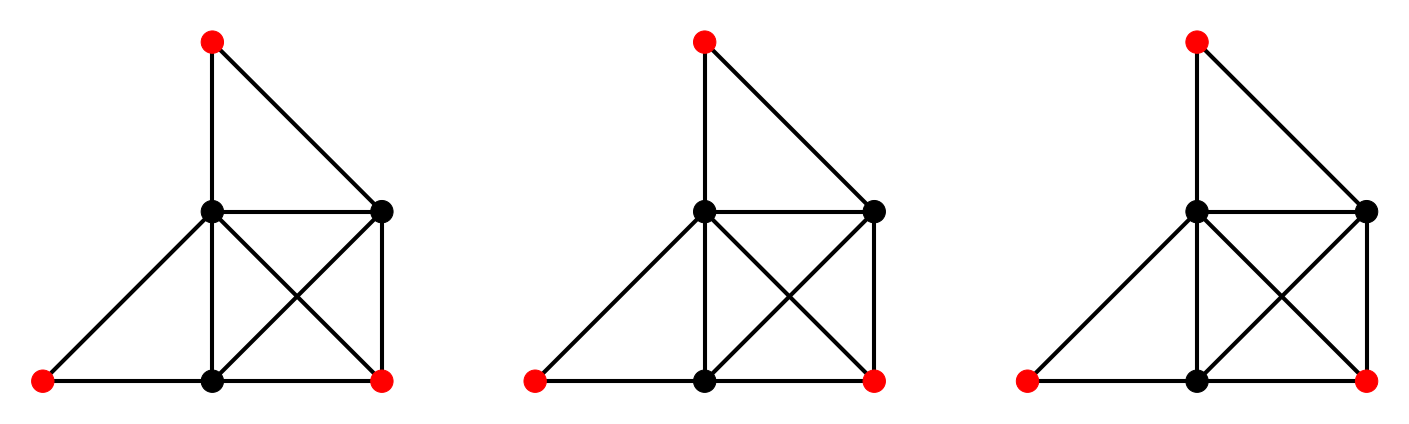

In [12]:
result_json = open_json("small_kings_graph_mis.json")
IS_sizes,pp_bitstrings = analysis_MIS(small_G,result_json)

ind, = np.where(IS_sizes==IS_sizes.max())
n_show = min(len(ind),3)

fig = plt.figure(figsize=(25,15))
for i in range(n_show):
    ax = plt.subplot(1,n_show,i+1)

    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[pp_bitstrings[ind[i]][j]] for j in range(len(pp_bitstrings[ind[i]]))]
    visualize_graph(ax,small_G,pos,node_colors = seqs_color)
    
plt.show()
    



# Executing the analog quantum program on Aquila

Now, we can try the same thing on QuEra's analog Hamiltonian simulator. Seeing as we can use many more qubits, let us leverage that, by constructing a Kings graph of 157 vertices.

Lattice constant is 4.783um


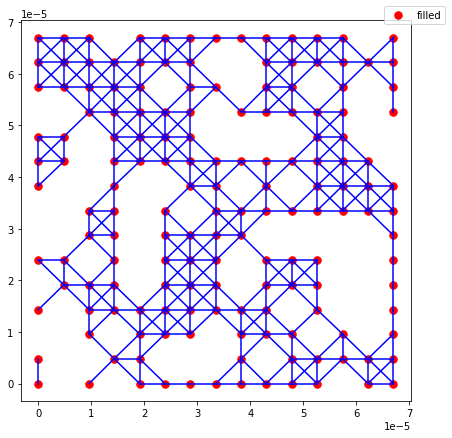

In [13]:
pos,G = kings_graph(15,15,0.7,seed = 2)


# Determine the scaling factor a
blockade_radius = (C6/(Delta_final))**(1/6)
unitdisk_radius,min_radius,max_radius = find_UDG_radius(pos,G)
a = blockade_radius / unitdisk_radius


print('Lattice constant is {:0.3f}um'.format(a*1e6))
register = AtomArrangement()
for x in pos:
    register.add([round(a * x[0],7), round(a*x[1],7)])
show_register(register,blockade_radius = a*1.5,show_atom_index=False)

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)


Lets run this on Aquila!

In [15]:
#raise BaseException("Only run this cell when you are ready to submit your job.")

from braket.aws import AwsDevice
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

nshots = 50
task = qpu.run(ahs_program, shots=nshots)
print(task)

save_result_json("large_kings_graph_mis.json",task.result())

AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:592242689881:quantum-task/fa70e04c-0d8e-430a-b7ea-c2a18dd31ea9')



KeyboardInterrupt



In [16]:
from braket.aws import AwsQuantumTask

In [17]:
task = AwsQuantumTask(arn="arn:aws:braket:us-east-1:592242689881:quantum-task/fa70e04c-0d8e-430a-b7ea-c2a18dd31ea9")

In [18]:
task.cancel()

KeyError: 'cancellationStatus'

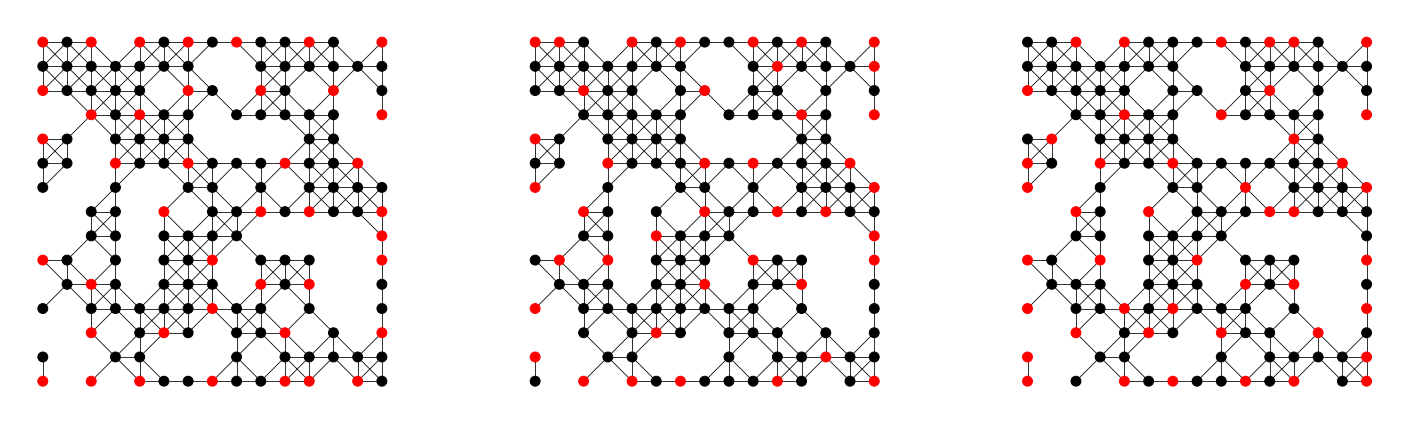

In [19]:
result_json = open_json("large_kings_graph_mis.json")
nmeas = len(result_json["measurements"])
seqs = [result_json["measurements"][i]["post_sequence"] for i in [0,nmeas-2,nmeas-1]]

fig = plt.figure(figsize=(25,15))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    
    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[seqs[i][j]] for j in range(len(seqs[i]))]
    visualize_graph(ax,G,pos,node_colors = seqs_color)
plt.show()

Average pre-processed size:  41.4100
Average post-processed IS size: 37.1719


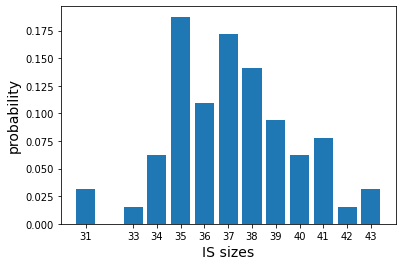

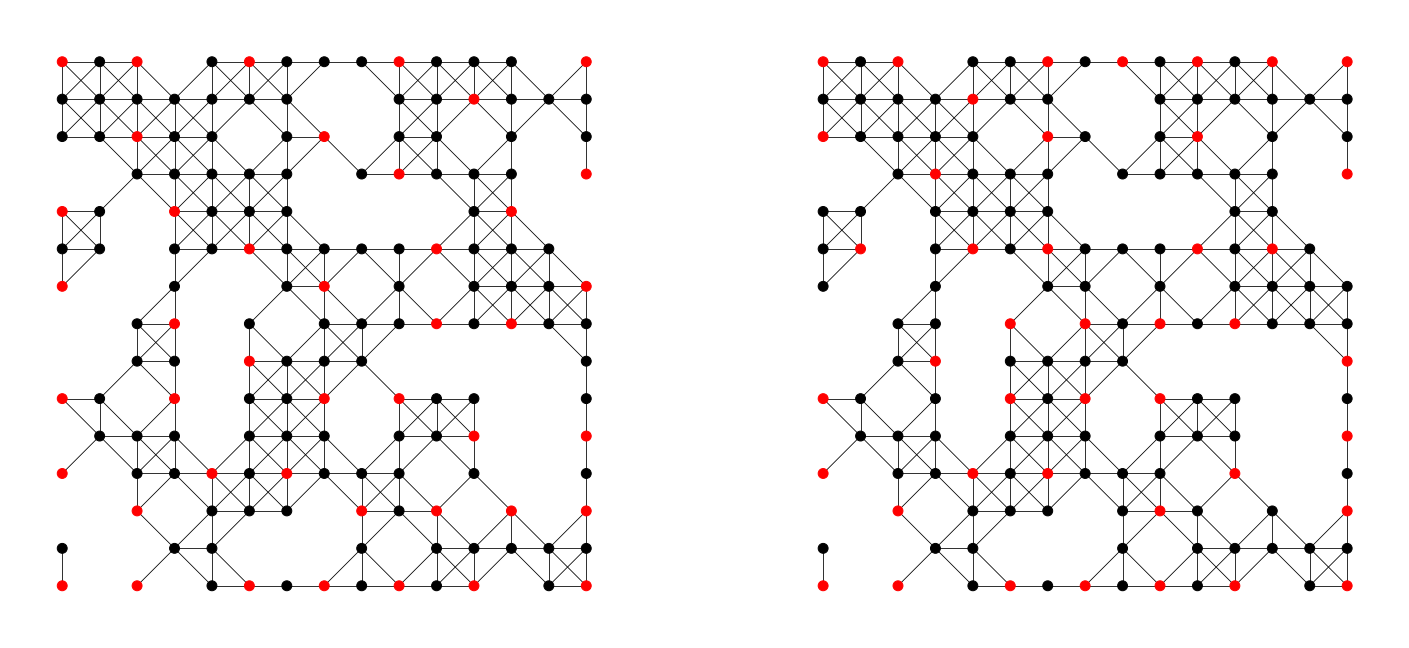

In [20]:
result_json = open_json("large_kings_graph_mis.json")
IS_sizes,pp_bitstrings = analysis_MIS(G,result_json)

ind, = np.where(IS_sizes==IS_sizes.max())
n_show = min(len(ind),3)

fig = plt.figure(figsize=(25,15))
for i in range(n_show):
    ax = plt.subplot(1,n_show,i+1)

    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[pp_bitstrings[ind[i]][j]] for j in range(len(pp_bitstrings[ind[i]]))]
    visualize_graph(ax,G,pos,node_colors = seqs_color)
    
plt.show()
    

## Real-world example: Locations in Boston

Finally, let us do a real-world example of computing MIS on locations in Boston. There are many examples of MIS, but one simple one is antenna placement: Given some potential locations of antennas, what is the maximum number you may choose such that no two antenna coverage areas overlap?

### Best Practices

In order to embed our problem onto Aquila we need to discuss how the device capabilities can be used effectively.

It is important to consider the physical limitations of the placements of atoms. These constraints are
1. The resolution of positions must be in increments of 100nm, eg. (1.5e-6, 2.4e-6) and not (1.234567e-6, 8.901e-6)
2. Each atom belongs to a row, and as many atoms as possible should share rows (the same y-coordinate). This effectively maximizes the number of atoms that can be arranged in the bounded area, due to the mechanism by which the atoms are configured using optical tweezers.
3. All rows must be at least 4um apart.
3. No atoms can be closer than 4um apart.

In [26]:
# Capabilities, constraints and performance metrics are stored as 'paradigm' attribute of AwsDevice.
capabilities = qpu.properties.paradigm

# print out lattice capabilities
pp(capabilities.lattice.dict())

{'area': {'height': Decimal('0.000076'), 'width': Decimal('0.000075')},
 'geometry': {'numberSitesMax': 256,
              'positionResolution': Decimal('1E-7'),
              'spacingRadialMin': Decimal('0.000004'),
              'spacingVerticalMin': Decimal('0.000004')}}


Let us load a map of Boston and 130 possible antenna locations

In [27]:
import matplotlib.image as mpimg
img = mpimg.imread('Boston_downtown.png')
BOSTON_downtown = open_json("Boston_university_locations.json")
boston_coordinates = np.array(BOSTON_downtown["lattice"])

boston_unitdisk_radius = 640 # meters

# Construct a unit disk graph as no two sites within 1500 feet of each other
boston_distances = np.sqrt((boston_coordinates[:,0] - boston_coordinates[:,0,None])**2 
                    + (boston_coordinates[:,1] - boston_coordinates[:,1,None])**2)
boston_G = nx.Graph(boston_distances<boston_unitdisk_radius)
boston_G.remove_edges_from(nx.selfloop_edges(boston_G))
boston_G = nx.relabel.convert_node_labels_to_integers(boston_G)



fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
visualize_graph(ax,boston_G,boston_coordinates)
plt.imshow(img,extent=[0,6000,0,6000])
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Boston_downtown.png'

Unit disk radius of logical graph is 640.000
Blockade radius is 8.044e-06
Scaling factor is 79558226.287um/m


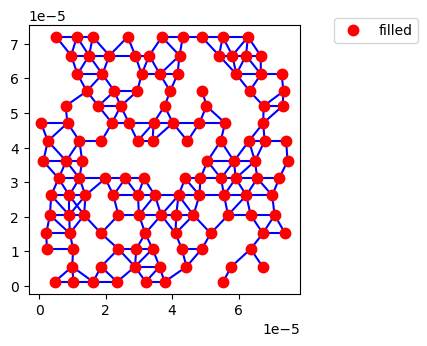

In [19]:
# Find unit disk radius
boston_unitdisk_radius,min_radius,max_radius = find_UDG_radius(boston_coordinates,boston_G)
print('Unit disk radius of logical graph is {:0.3f}'.format(boston_unitdisk_radius))
print('Blockade radius is {:0.3e}'.format(blockade_radius))
a = blockade_radius / boston_unitdisk_radius
print('Scaling factor is {:0.3f}um/m'.format(1/a))
boston_register = AtomArrangement()
for x in boston_coordinates:
    boston_register.add([round(a * x[0],7), round(a*x[1],7)])
show_register(boston_register,blockade_radius = blockade_radius,show_atom_index=False)

boston_ahs_program = AnalogHamiltonianSimulation(
    register=boston_register, 
    hamiltonian=drive
)

In [20]:
raise BaseException("Only run this cell when you are ready to submit your job.")

nshots = 1000
task = qpu.run(boston_ahs_program, shots=nshots)
print(task)

# save_result_json("boston_graph_mis.json",task.result())

BaseException: Only run this cell when you are ready to submit your job.

**Analyze MIS results**

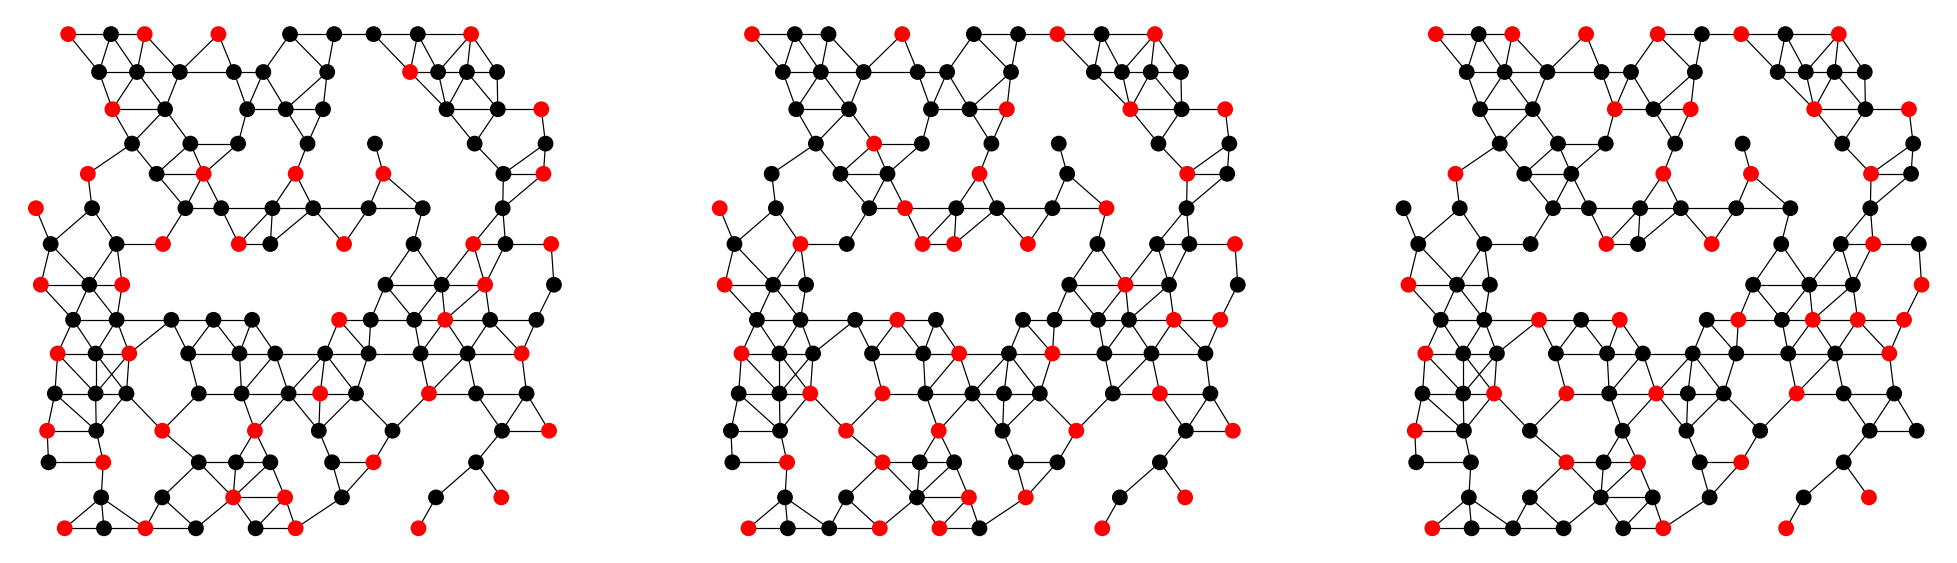

In [21]:
result_json = open_json("boston_graph_mis.json")

seqs = [result_json["measurements"][i]["post_sequence"] for i in range(3)]

fig = plt.figure(figsize=(25,15))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    
    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[seqs[i][j]] for j in range(len(seqs[i]))]
    visualize_graph(ax,boston_G,boston_coordinates,node_colors = seqs_color)
plt.show()

Average pre-processed size:  40.5960
Average post-processed IS size: 37.9480


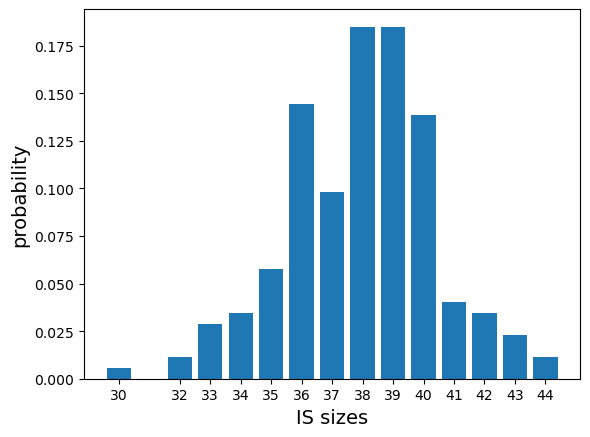

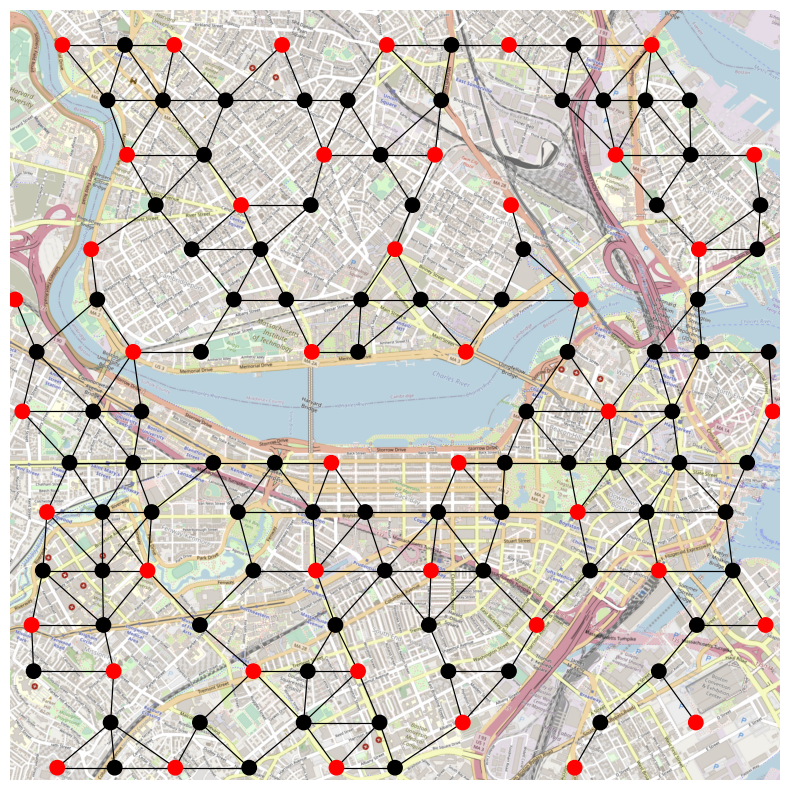

In [22]:
result_json = open_json("boston_graph_mis.json")
IS_sizes,pp_bitstrings = analysis_MIS(boston_G,result_json)

ind, = np.where(IS_sizes==IS_sizes.max())
n_show = 1#min(len(ind),3)

fig = plt.figure(figsize=(10,10))
for i in range(n_show):
    ax = plt.subplot(1,n_show,i+1)

    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[pp_bitstrings[ind[i]][j]] for j in range(len(pp_bitstrings[ind[i]]))]
    visualize_graph(ax,boston_G,boston_coordinates,node_colors = seqs_color)
    plt.imshow(img,extent=[0,6000,0,6000])
    
plt.show()